In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

%matplotlib notebook

register_matplotlib_converters()

In [2]:
# 从 Yahoo Finance 下载历史数据
tickers = [
    'SPY',   # S&P500 ETF
    'IEF',   # 7-10 year US treasury bond ETF
    'AAPL',  # Apple stock
]

# data contains trading days only
data = yf.download(
    tickers = tickers,
    period = 'max',
    interval = '1d',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True).dropna()

# download SSE Composite Index separately 
# because data of this index on Yahoo finance is incomplete
ssec_data = yf.download(
    tickers = '^SSEC',
    period = 'max',
    interval = '1d',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True).dropna()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


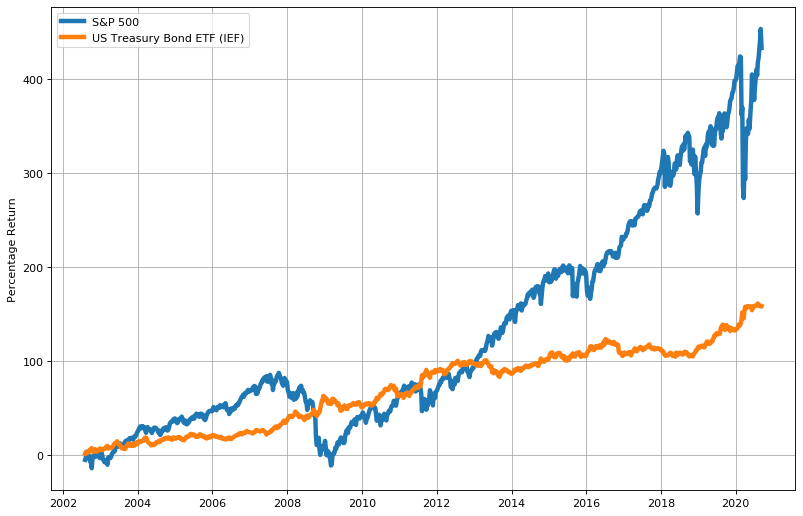

In [3]:
sp500 = data['SPY']['Close'].to_numpy()
bond= data['IEF']['Close'].to_numpy()

# 计算 5 个交易日的累计收益，近似 weekly returns
sp500_wk = sp500[::5]
bond_wk = bond[::5]
sp500_wk_ret = sp500_wk[1:]/sp500_wk[:-1]
bond_wk_ret = bond_wk[1:]/bond_wk[:-1]

index_wk = data.index[::5]
index_wk = index_wk[1:]

assert(len(index_wk)==len(bond_wk_ret))

fig1 = plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(index_wk, (np.cumprod(sp500_wk_ret)-1)*100, color='C0', linewidth=4)
ax.plot(index_wk, (np.cumprod(bond_wk_ret)-1)*100, color='C1', linewidth=4)
ax.legend(['S&P 500', 'US Treasury Bond ETF (IEF)'])
ax.set_ylabel('Percentage Return')
ax.grid()

Text(0, 0.5, 'Return (%)')

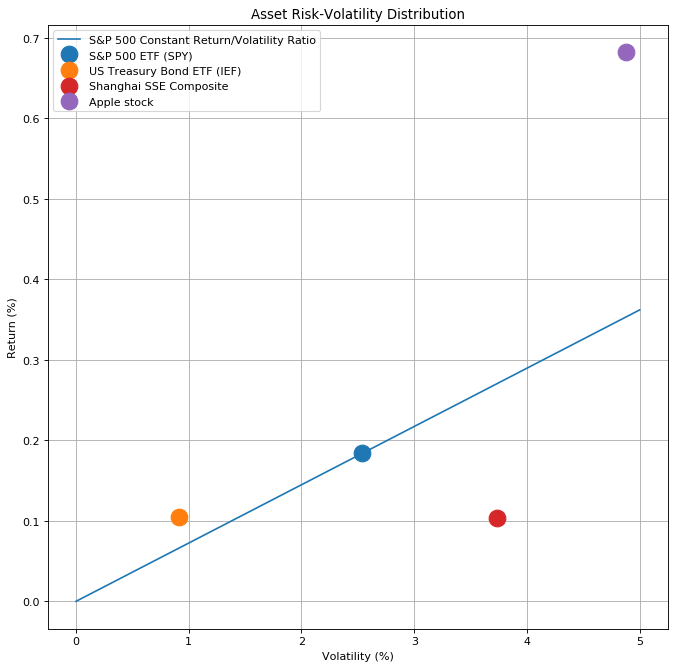

In [4]:

# 计算每周 log return 的平均值与标准差，再换算成百分比。
def ComputeReturnAndVolatility(returns):

    mean = (np.exp(np.mean(np.log(returns))) - 1) * 100
    sigma = (np.exp(np.std(np.log(returns))) - 1) * 100

    return mean, sigma

ssec = ssec_data['Close'].to_numpy()
ssec_wk = ssec[::5]
ssec_wk_ret = ssec_wk[1:]/ssec_wk[:-1]

apple = data['AAPL']['Close'].to_numpy()
apple_wk = apple[::5]
apple_wk_ret = apple_wk[1:]/apple_wk[:-1]

ssec_ret_mean, ssec_ret_sigma = ComputeReturnAndVolatility(ssec_wk_ret)
sp500_ret_mean, sp500_ret_sigma = ComputeReturnAndVolatility(sp500_wk_ret)
bond_ret_mean, bond_ret_sigma = ComputeReturnAndVolatility(bond_wk_ret)
apple_ret_mean, apple_ret_sigma = ComputeReturnAndVolatility(apple_wk_ret)

sp500_line_x = np.linspace(0, 5, 5)
sp500_line_y = sp500_line_x * sp500_ret_mean / sp500_ret_sigma

fig1 = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(sp500_line_x, sp500_line_y, color='C0')
ax.plot(sp500_ret_sigma, sp500_ret_mean, '.', color='C0', markersize=30)
ax.plot(bond_ret_sigma, bond_ret_mean, '.', color='C1', markersize=30)
ax.plot(ssec_ret_sigma, ssec_ret_mean, '.', color='C3', markersize=30)
ax.plot(apple_ret_sigma, apple_ret_mean, '.', color='C4', markersize=30)
ax.legend(['S&P 500 Constant Return/Volatility Ratio', 
           'S&P 500 ETF (SPY)', 
           'US Treasury Bond ETF (IEF)',
           'Shanghai SSE Composite', 
           'Apple stock'])

ax.grid()
ax.set_title('Asset Risk-Volatility Distribution')
ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Return (%)')

[*********************100%***********************]  1 of 1 completed


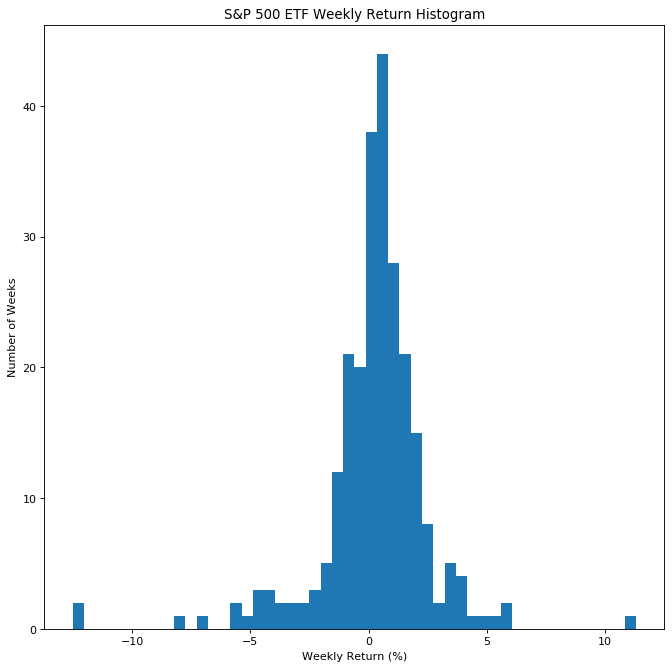

In [5]:
sp500_data = yf.download(
    tickers = '^GSPC', # SP500 index ticker on Yahoo Finance
    period = '5y',
    interval = '1d',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True).dropna()

sp500 = sp500_data['Close'].to_numpy()
sp500_wk = sp500[::5]
sp500_wk_ret = sp500_wk[1:]/sp500_wk[:-1]

fig1 = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.hist((sp500_wk_ret-1) * 100, bins=50)
ax.set_title('S&P 500 ETF Weekly Return Histogram')
ax.set_xlabel('Weekly Return (%)')
ax.set_ylabel('Number of Weeks')
plt.show()